## Data Wrangling project  We Rate Dogs


## Acknoledgment
- Refences used were Github
- the visualisation was coppied due to the time frame shortage and ammended according to ax system 

## TABLE OF CONTENTS
- [Introduction](#introduction)
- [Gathering](#gathering)
- [Assessing](#assessing)
- [Cleaning](#clean)
- [Storing](#store)
- [Analysing](#analyse)

<a id = 'introduction'></a>

## INTRODUCTION


it is needed in our modern world to bring data in a clean form , which is suitable for analysis .\n
Thus, witht the aid of python libraries , the data will be collectd from various resources to asses the dog rating , incuding an online resource such as twitter.
The documentation will include the data cleaning , data wrangling and data analysis applied for the collection of the resources for the Dog rating.


- the dataset to be wrangled will include the [@dog_rates_twitter_link](https://twitter.com/dog_rates), 
- the twitter account[WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs)

    - the main fucntion of the we rate dogs is to comment on the dogs in a humirious way.
    - the rating has a  humirous way of scaling it start with 10 and always exeeeding it accoording to the regulations set by ["they're good dogs Brent."](https://knowyourmeme.com/memes/theyre-good-dogs-brent)
    - the number of followers for WeRateDogs exceeds 4 million with international media coverage.  


In [240]:
#Importing the essential libraries
# Import the necessary libraries
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import time
import math
import os
import matplotlib as plt
import datetime
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tweepy
import requests
import pandas as pd
import json
import time
import math
import re

<a id = 'gathering'></a>
## GATHERING
there are three dataframes that are going to be gahtered using th following steps:

1. the WeRateDogs twitter archive: which will bedownloaded programaticly through the following URL [link](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)


2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.This file `image_predictions.tsv` is hosted on Udacity's servers and should be downloaded programmatically using the **Requests** library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv


3. Each tweet's retweet count and favorite ("like") count. Using the tweet IDs in the WeRateDogs Twitter archive, we will query the Twitter API for each tweet's JSON data using Python's **Tweepy** library and store each tweet's entire set of JSON data in a file called `tweet_json.txt file`. Each tweet's JSON data should be written to its own line. Then we will read this .txt file line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count.

**1-loading the twitter file  `twitter-archive-enhanced.csv`**

In [3]:
#loading the archive for twitter data
tweet_df = pd.read_csv('twitter-archive-enhanced.csv')
tweet_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**2-Downloading the missing data programatically using the `image-predictions.tsv`**

In [4]:
# Make directory if it doesn't already exist
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
#using the response ger url function , no need to redo again 
response= requests.get(url)
with open(os.path.join(folder_name,url.split('/')[-1]),mode='wb') as f:
    f.write(response.content)

In [5]:
#loading the image_prediction file 
image_df = pd.read_csv('image-predictions.tsv')
image_df.head()

,tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog
0,666020888022790149\thttps://pbs.twimg.com/medi...
1,666029285002620928\thttps://pbs.twimg.com/medi...
2,666033412701032449\thttps://pbs.twimg.com/medi...
3,666044226329800704\thttps://pbs.twimg.com/medi...
4,666049248165822465\thttps://pbs.twimg.com/medi...


In [6]:
#wrong indexing , thus a separqation between them is needed
image_df = pd.read_csv('image-predictions.tsv',sep='\t')
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**3-importing the data using tweepy api  and storing it in `tweet_json.txt`**

**PSI , we are importing information using the tweet ID to gather the retweet count and favoured count. note that the twitter API, tokkens and secrets are kept confidential for security issues **

In [7]:
#importing Tweepy api and other essentials
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
#Queering the API in the form of an archive , and saving the gahtered data in json.txt
consumer_key='confidential'
consumer_secret='confidential'
access_token='confidential'
access_secret='confidential'
auth = OAuthHandler(consumer_key,consumer_key)
auth.set_access_token=(access_token,access_secret)

api=tweepy.API(auth,wait_on_rate_limit=True)

#using tweet ID form image predictions to gather the post and tweets count info
tweet_ids=tweet_df.tweet_id.values
#gathering the lenghts of tweets
len(tweet_ids)

#Creating a Query for each tweet ID using twitter's API
count = 0
fails_dict = {}
start= timer()
# Save each tweat in a new Json line separated by ':' in a tweet_json.txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 30 minutes or more to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()

1: 892420643555336193
Fail
2: 892177421306343426
Fail
3: 891815181378084864
Fail
4: 891689557279858688
Fail
5: 891327558926688256
Fail
6: 891087950875897856
Fail
7: 890971913173991426
Fail
8: 890729181411237888
Fail
9: 890609185150312448
Fail
10: 890240255349198849
Fail
11: 890006608113172480
Fail
12: 889880896479866881
Fail
13: 889665388333682689
Fail
14: 889638837579907072
Fail
15: 889531135344209921
Fail
16: 889278841981685760
Fail
17: 888917238123831296
Fail
18: 888804989199671297
Fail
19: 888554962724278272
Fail
20: 888202515573088257
Fail
21: 888078434458587136
Fail
22: 887705289381826560
Fail
23: 887517139158093824
Fail
24: 887473957103951883
Fail
25: 887343217045368832
Fail
26: 887101392804085760
Fail
27: 886983233522544640
Fail
28: 886736880519319552
Fail
29: 886680336477933568
Fail
30: 886366144734445568
Fail
31: 886267009285017600
Fail
32: 886258384151887873
Fail
33: 886054160059072513
Fail
34: 885984800019947520
Fail
35: 885528943205470208
Fail
36: 885518971528720385
Fail
3

Fail
288: 838561493054533637
Fail
289: 838476387338051585
Fail
290: 838201503651401729
Fail
291: 838150277551247360
Fail
292: 838085839343206401
Fail
293: 838083903487373313
Fail
294: 837820167694528512
Fail
295: 837482249356513284
Fail
296: 837471256429613056
Fail
297: 837366284874571778
Fail
298: 837110210464448512
Fail
299: 837012587749474308
Fail
300: 836989968035819520
Fail
301: 836753516572119041
Fail
302: 836677758902222849
Fail
303: 836648853927522308
Fail
304: 836397794269200385
Fail
305: 836380477523124226
Fail
306: 836260088725786625
Fail
307: 836001077879255040
Fail
308: 835685285446955009
Fail
309: 835574547218894849
Fail
310: 835536468978302976
Fail
311: 835309094223372289
Fail
312: 835297930240217089
Fail
313: 835264098648616962
Fail
314: 835246439529840640
Fail
315: 835172783151792128
Fail
316: 835152434251116546
Fail
317: 834931633769889797
Fail
318: 834786237630337024
Fail
319: 834574053763584002
Fail
320: 834477809192075265
Fail
321: 834458053273591808
Fail
322: 8342

Fail
571: 801854953262350336
Fail
572: 801538201127157760
Fail
573: 801285448605831168
Fail
574: 801167903437357056
Fail
575: 801127390143516673
Fail
576: 801115127852503040
Fail
577: 800859414831898624
Fail
578: 800855607700029440
Fail
579: 800751577355128832
Fail
580: 800513324630806528
Fail
581: 800459316964663297
Fail
582: 800443802682937345
Fail
583: 800388270626521089
Fail
584: 800188575492947969
Fail
585: 800141422401830912
Fail
586: 800018252395122689
Fail
587: 799774291445383169
Fail
588: 799757965289017345
Fail
589: 799422933579902976
Fail
590: 799308762079035393
Fail
591: 799297110730567681
Fail
592: 799063482566066176
Fail
593: 798933969379225600
Fail
594: 798925684722855936
Fail
595: 798705661114773508
Fail
596: 798701998996647937
Fail
597: 798697898615730177
Fail
598: 798694562394996736
Fail
599: 798686750113755136
Fail
600: 798682547630837760
Fail
601: 798673117451325440
Fail
602: 798665375516884993
Fail
603: 798644042770751489
Fail
604: 798628517273620480
Fail
605: 7985

KeyboardInterrupt: 

**4-reading the  `tweet_json.txt` and importing the dataframe for retweetcounts, favoured counts and Tweet ID**


In [8]:
#Ensure the proper appending and encoding tools 

In [9]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame, with encoding opening
#dictionary created
df_info=[]
#read Json file for each line
with open('tweet-json.txt', 'r',encoding='utf-8') as json_file:
    for line in json_file:
        # using json.loads() 
        # convert dictionary string to dictionary 
        tweet_info = json.loads(line)
        
        # Append  each line to the dictionary
        df_info.append({'tweet_id': tweet_info['id'],'retweet_count': tweet_info['retweet_count'],
                        'favorite_count': tweet_info['favorite_count'],
                        'display_text_range': tweet_info['display_text_range']
                       })

# Building the  DataFrame with tweet ID, retweet count, favorite count and display_text_range
tweet_info = pd.DataFrame(df_info, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

In [10]:
tweet_info.head(4)

,tweet_id,retweet_count,favorite_count,display_text_range
0,892420643555336193,8853,39467,"[0, 85]"
1,892177421306343426,6514,33819,"[0, 138]"
2,891815181378084864,4328,25461,"[0, 121]"
3,891689557279858688,8964,42908,"[0, 79]"


In [11]:
image_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1467,778748913645780993,https://pbs.twimg.com/media/Cs6r_-kVIAALh1p.jpg,1,Staffordshire_bullterrier,0.351434,True,boxer,0.201478,True,American_Staffordshire_terrier,0.142838,True
1112,724049859469295616,https://pbs.twimg.com/media/CgxXf1TWYAEjY61.jpg,1,Border_collie,0.581835,True,collie,0.344588,True,Shetland_sheepdog,0.043584,True
71,667200525029539841,https://pbs.twimg.com/media/CUJfVMPXIAAgbue.jpg,1,Siberian_husky,0.694904,True,malamute,0.232006,True,Eskimo_dog,0.050635,True
487,675501075957489664,https://pbs.twimg.com/media/CV_cnjHWUAADc-c.jpg,1,dough,0.806757,False,bakery,0.027907,False,French_loaf,0.018189,False
815,692752401762250755,https://pbs.twimg.com/tweet_video_thumb/CZ0mhd...,1,Samoyed,0.471276,True,Siberian_husky,0.158850,True,Eskimo_dog,0.138672,True


In [12]:
tweet_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


<a id = 'assessing'></a>
## Assessing
Assesing involves  the inspection of our collected data sets from both the Quality and Tidiness perspectives will be conducted
minimum 8 quality and two tidy issues to be detected.
Here, we will Asses the data quality and tidiness :


1. Visual assesment for Quality issues/n

    **Quality criteria**
        - completness
        - validity
        - accuracy
        - consistancy
    
    
    
    **Quality issues discovered visually**
 - incomplete names for `name` in `tweet_df`
 - (Nan) values in `retweeted_status_timestamp`, and need to be integer
 - retweet ID(Nan) `retweeted_status_user_id` and need to be integer
 - status (Nan) `in_reply_to_status_id` and need to an integer
 - Changing the  `retweeted_status_id` and `retweeted_status_user_id`  to integer

2. Programatic assesment for qualtity issues

`tweet_df`
- `timestamp` must be in date format
- `retweeted_status_timestamp` must be also in data format
- `in_reply_to_status_id ` and `in_reply_to_user_id` must be integers with non- null values
- `None` and `a` apperance in `name` variable
- `rating_denominator` is varying with some of the values are not 10 
- melt and provide categories for `doggo' ,'floofer` ,`pupper` and `puppo`

`tweet_info`
- `display_text_range` is displayed as an object while ti shoudld be an integer
- some values are outliers such as the `1776` in the `rating_numerator` function
- replicaed `tweet_id`
- `tweet_id` values are not the same as in `tweet_df`

`image_df`
- No issues displayed


3. Tidiness visual assesment/n

    **Tidiness criteria**
    
    - every row is an observation 
    - every column is a variable
    - every type of observational assesment forms a table  
    **Tidiness issues discovered visually**
    - `display_text_range`  needs to be separated in `tweet_info`
    - `Time`
    - `tweet_id` must be simmilar in both `tweet_df` and `image_df`

In [13]:
#Information check
tweet_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
#information check
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
#information check
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   display_text_range  2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [16]:
tweet_info.display_text_range.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[0, 140]     260
[0, 139]     147
[0, 138]      80
[0, 137]      78
[0, 116]      59
            ... 
[13, 105]      1
[0, 42]        1
[30, 60]       1
[0, 13]        1
[0, 18]        1
Name: display_text_range, Length: 143, dtype: int64

In [17]:
# Check if there are any duplicate ids
tweet_info[tweet_info.tweet_id.duplicated()]

,tweet_id,retweet_count,favorite_count,display_text_range


In [18]:
tweet_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
#information check
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
#describtion  check
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [21]:
#describtion  check
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [22]:
#describtion  check
tweet_info.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [23]:
tweet_df.rating_numerator.value_counts()            

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [24]:
tweet_df.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Lulu         1
Vixen        1
Al           1
Chloe        1
Chase        1
Name: name, Length: 957, dtype: int64

In [25]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [26]:
#Duplicates check
tweet_df[tweet_df.tweet_id.duplicated() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [27]:
#Duplicates check
tweet_df[tweet_df.duplicated() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [28]:
#Duplicates check
image_df[image_df.duplicated() == True]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [29]:
tweet_info[tweet_info.tweet_id.duplicated()==True]

,tweet_id,retweet_count,favorite_count,display_text_range


<a id = 'clean'></a>

## Cleanning 


The cleanning process is essential to be able to use the data and analyse it properly for the three data frames noted

`tweet_df`   ,`tweet_info` and `image_df`

with fixing the tidiness and quality issues as stated above


In [30]:
tweet_dfclean=tweet_df.copy()

In [31]:
tweet_dfclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Define
##### Define
 Extact an informative text from `tweet_dfclean` text column column Using the `display_text_range`

In [32]:
# extracting the first three records using iloc row slicing
print(tweet_dfclean.iloc[0].text)
print(tweet_dfclean.iloc[1].text)
print(tweet_dfclean.iloc[2].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB


In [33]:
# merge status_df's display_text_range column to archive_clean to extract text using range values
tweet_dfclean = pd.merge(tweet_dfclean, tweet_info[['tweet_id', 'display_text_range']], on='tweet_id')

In [34]:
# using display_text_range of archive_clean, extract displayable text
for i, row in tweet_dfclean.iterrows():
    text_range = row.display_text_range
    display_text = row.text[text_range[0]:text_range[1]]
    tweet_dfclean.at[i, 'text'] = display_text

In [35]:
tweet_dfclean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,display_text_range
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,"[0, 85]"
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,"[0, 138]"
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,"[0, 121]"
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,"[0, 79]"
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,"[0, 138]"


In [36]:
# drop display_text_range column
tweet_dfclean.drop('display_text_range', axis=1, inplace=True)

Code

Test 

In [37]:
# Check after replacement
print(tweet_dfclean.iloc[0].text)
print(tweet_dfclean.iloc[1].text)
print(tweet_dfclean.iloc[2].text)

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10


Define : Making `timestamp` string to datetime

Code 

In [38]:
tweet_dfclean.timestamp=pd.to_datetime(tweet_dfclean.timestamp)

Test

In [39]:
tweet_dfclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2354 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2354 non-null   datetime64[ns, UTC]
 4   source                      2354 non-null   object             
 5   text                        2354 non-null   object             
 6   retweeted_status_id         179 non-null    float64            
 7   retweeted_status_user_id    179 non-null    float64            
 8   retweeted_status_timestamp  179 non-null    object             
 9   expanded_urls               2295 non-null   object             
 10  rating_numerator            2354 non-null   int64           

In [40]:
tweet_dfclean.in_reply_to_user_id.value_counts()

4.196984e+09    47
2.195506e+07     2
7.305050e+17     1
2.916630e+07     1
3.105441e+09     1
2.918590e+08     1
2.792810e+08     1
2.319108e+09     1
1.806710e+08     1
3.058208e+07     1
2.625958e+07     1
1.943518e+08     1
3.589728e+08     1
8.405479e+17     1
2.894131e+09     1
2.143566e+07     1
2.281182e+09     1
1.648776e+07     1
4.717297e+09     1
2.878549e+07     1
1.582854e+09     1
4.670367e+08     1
4.738443e+07     1
1.361572e+07     1
1.584641e+07     1
2.068372e+07     1
1.637468e+07     1
1.185634e+07     1
1.198989e+09     1
1.132119e+08     1
7.759620e+07     1
Name: in_reply_to_user_id, dtype: int64

## Define

Cleaning the Nan values in `in_reply_to_user_id` and `in_reply_to_status_id` by filling the nan with zeros and change to integer

## Code

In [41]:
tweet_dfclean.in_reply_to_status_id = tweet_dfclean.in_reply_to_status_id.fillna(0)

In [42]:
tweet_dfclean.in_reply_to_status_id = tweet_dfclean.in_reply_to_status_id.astype(np.int64)

In [43]:
tweet_dfclean.in_reply_to_user_id = tweet_dfclean.in_reply_to_user_id.fillna(0)

In [44]:
tweet_dfclean.in_reply_to_user_id = tweet_dfclean.in_reply_to_user_id.astype(np.int64)

## Test

In [45]:
tweet_dfclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2354 non-null   int64              
 1   in_reply_to_status_id       2354 non-null   int64              
 2   in_reply_to_user_id         2354 non-null   int64              
 3   timestamp                   2354 non-null   datetime64[ns, UTC]
 4   source                      2354 non-null   object             
 5   text                        2354 non-null   object             
 6   retweeted_status_id         179 non-null    float64            
 7   retweeted_status_user_id    179 non-null    float64            
 8   retweeted_status_timestamp  179 non-null    object             
 9   expanded_urls               2295 non-null   object             
 10  rating_numerator            2354 non-null   int64           

In [46]:
tweet_dfclean.retweeted_status_id.value_counts()

7.757333e+17    1
7.827226e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
               ..
7.806013e+17    1
8.305833e+17    1
7.047611e+17    1
7.399792e+17    1
7.331095e+17    1
Name: retweeted_status_id, Length: 179, dtype: int64

In [47]:
tweet_dfclean.retweeted_status_user_id.value_counts().value_counts()

1      22
155     1
2       1
Name: retweeted_status_user_id, dtype: int64

In [48]:
tweet_dfclean.in_reply_to_status_id = tweet_dfclean.in_reply_to_status_id.astype(np.int64)

## Define

Changing the  `retweeted_status_id` and `retweeted_status_user_id`  to integer with cleanning null values

## Code

In [49]:
tweet_dfclean = tweet_dfclean[tweet_dfclean.retweeted_status_id.isnull()]

In [50]:
tweet_dfclean=tweet_dfclean[tweet_dfclean.retweeted_status_id.isnull()]

In [51]:
tweet_dfclean.retweeted_status_id = tweet_dfclean.retweeted_status_id.fillna(0)

In [52]:
tweet_dfclean.retweeted_status_id = tweet_dfclean.retweeted_status_id.astype(np.int64)

In [53]:
tweet_dfclean.retweeted_status_user_id = tweet_dfclean.retweeted_status_user_id.fillna(0)

In [54]:
tweet_dfclean.retweeted_status_user_id = tweet_dfclean.retweeted_status_user_id.astype(np.int64)

In [55]:
tweet_dfclean=tweet_dfclean[tweet_dfclean.tweet_id.isin(tweet_info.tweet_id)]

## Test

In [56]:
len(tweet_dfclean[tweet_dfclean.retweeted_status_id.isnull()== False])

2175

In [57]:
len(tweet_dfclean[~tweet_dfclean.tweet_id.isin(tweet_info.tweet_id)])

0

In [58]:
tweet_dfclean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
840,766793450729734144,0,0,2016-08-20 00:26:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Rufus. He just missed out on the 100m ...,0,0,NaN,https://twitter.com/dog_rates/status/766793450...,10,10,Rufus,None,None,None,None
1567,687807801670897665,0,0,2016-01-15 01:25:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Trooper &amp; Maya. Trooper protects Maya...,0,0,NaN,https://twitter.com/dog_rates/status/687807801...,11,10,Trooper,None,None,None,None
1721,680100725817409536,0,0,2015-12-24 19:00:23+00:00,"<a href=""https://about.twitter.com/products/tw...",This pupper is not coming inside until she cat...,0,0,NaN,https://twitter.com/dog_rates/status/680100725...,11,10,None,None,None,pupper,None
1145,726935089318363137,0,0,2016-05-02 00:43:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sprout. He's just precious af. 12/10 I...,0,0,NaN,https://twitter.com/dog_rates/status/726935089...,12,10,Sprout,None,None,None,None
804,772114945936949249,0,0,2016-09-03 16:52:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Finn. He's very nervous for the game. ...,0,0,NaN,https://twitter.com/dog_rates/status/772114945...,10,10,Finn,None,None,None,None


## Define

 check on `retweeted_status_timestamp` values and convert it to dataframe

In [59]:
tweet_dfclean.retweeted_status_timestamp.value_counts()

Series([], Name: retweeted_status_timestamp, dtype: int64)

## Code

In [60]:
tweet_dfclean.retweeted_status_timestamp=pd.to_datetime(tweet_dfclean.retweeted_status_timestamp)

## Test

In [61]:
tweet_dfclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2353
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   int64              
 1   in_reply_to_status_id       2175 non-null   int64              
 2   in_reply_to_user_id         2175 non-null   int64              
 3   timestamp                   2175 non-null   datetime64[ns, UTC]
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         2175 non-null   int64              
 7   retweeted_status_user_id    2175 non-null   int64              
 8   retweeted_status_timestamp  0 non-null      datetime64[ns]     
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

In [62]:
#define

In [63]:
#cleaning extra duplicated urls

In [64]:
#code

In [65]:
#tweet_dfclean = tweet_dfclean[tweet_dfclean.retweeted_status_id.isnull()]

In [66]:
# Fill the missing values
#tweet_dfclean.expanded_urls = 'https://twitter.com/dog_rates/status/' + tweet_dfclean.tweet_id.astype(str) 

In [67]:
#test 

In [68]:
#tweet_dfclean[tweet_dfclean.expanded_urls.isnull() == True]

## Define

`None` and `a` apperance in `name` variable , since the name is not needed in the analysis and most likley it is repeated , it can be droped , we are more concerned about the type of the dogs

In [69]:
tweet_dfclean.name.value_counts()

None       680
a           55
Charlie     11
Lucy        11
Cooper      10
          ... 
Buckley      1
Bayley       1
Ralphie      1
Flash        1
Chase        1
Name: name, Length: 956, dtype: int64

## Code

In [70]:
tweet_dfclean['name'][tweet_dfclean['name'].str.match('[a-z]+')] = 'None'

In [71]:
#tweet_dfclean.drop('name', axis=1, inplace=True)

## Test

In [72]:
tweet_dfclean.name[tweet_dfclean.name=='None'].value_counts()

None    784
Name: name, dtype: int64

In [73]:
#Sort the name in descending order
tweet_dfclean.name.value_counts().sort_index(ascending=False)

Zuzu     1
Zooey    1
Zoey     3
Zoe      1
Ziva     1
        ..
Aiden    1
Adele    1
Acro     1
Ace      1
Abby     2
Name: name, Length: 931, dtype: int64

In [74]:
tweet_dfclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2353
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   int64              
 1   in_reply_to_status_id       2175 non-null   int64              
 2   in_reply_to_user_id         2175 non-null   int64              
 3   timestamp                   2175 non-null   datetime64[ns, UTC]
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         2175 non-null   int64              
 7   retweeted_status_user_id    2175 non-null   int64              
 8   retweeted_status_timestamp  0 non-null      datetime64[ns]     
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

3. Tidiness visual assesment/n

    **Tidiness criteria**
    
    - every row is an observation 
    - every column is a variable
    - every type of observational assesment forms a table  
    **Tidiness issues discovered visually**
    - `display_text_range`  needs to be separated in `tweet_info`
    - `Time`
    - `source` separation of website links
    - merging columns needed together are breed , retweet counts and favourite counts

## Define

cleanning the unnessecary information from `source` in `tweet_dfclean` and extacting the type of device used for the tweet.

remove (i.e. `<a..></a>`) in *source* column and extract the text between tags. Convert the datatype from string to categorical.

## clean

In [75]:
tweet_dfclean.source=tweet_df.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')

In [76]:
tweet_dfclean.source=tweet_dfclean.source.astype('category')

## test

In [77]:
tweet_dfclean.source.value_counts()

Twitter for iPhone     2045
Vine - Make a Scene      88
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

## Define

- melt and provide categories for   `floofer` , `pupper` , `puppo` and  `doggo'

In [78]:
tweet_dfclean.doggo.value_counts()

None     2088
doggo      87
Name: doggo, dtype: int64

In [79]:
tweet_dfclean.floofer.value_counts()

None       2165
floofer      10
Name: floofer, dtype: int64

In [80]:
tweet_dfclean.pupper.value_counts()

None      1941
pupper     234
Name: pupper, dtype: int64

In [81]:
tweet_dfclean.puppo.value_counts()

None     2150
puppo      25
Name: puppo, dtype: int64

## Code

In [82]:
# Replace the none values  with empty string , note : no need for the metling function with those strings
tweet_dfclean[['doggo', 'floofer', 'pupper', 'puppo']] = tweet_dfclean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')

In [83]:
#Adding a new column called dogphase 
tweet_dfclean['dog_phase']=tweet_dfclean['doggo']+tweet_dfclean['floofer']+tweet_dfclean['pupper']+tweet_dfclean['puppo']

In [84]:
tweet_dfclean.dog_phase.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_phase, dtype: int64

In [85]:
#replace the mixed ones with multiples
tweet_dfclean.dog_phase=tweet_dfclean.dog_phase.replace('doggopupper','multiple')
tweet_dfclean.dog_phase=tweet_dfclean.dog_phase.replace('doggopuppo','multiple')
tweet_dfclean.dog_phase=tweet_dfclean.dog_phase.replace('doggofloofer','multiple')

## Test

In [86]:
# changing the values to categories
tweet_dfclean.dog_phase = tweet_dfclean.dog_phase.astype('category')

In [87]:
tweet_dfclean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_phase
1484,693109034023534592,0,0,2016-01-29 16:30:45+00:00,Twitter for iPhone,"""Thank you friend that was a swell petting"" 11...",0,0,NaT,https://twitter.com/dog_rates/status/693109034...,11,10,None,,,,,
1302,707411934438625280,0,0,2016-03-09 03:45:22+00:00,Twitter for iPhone,"""I shall trip the big pupper with leash. Big p...",0,0,NaT,https://twitter.com/dog_rates/status/707411934...,11,10,None,,,pupper,,pupper
1556,688789766343622656,0,0,2016-01-17 18:27:32+00:00,Twitter for iPhone,Meet Pubert. He's a Kerplunk Rumplestilt. Cann...,0,0,NaT,https://twitter.com/dog_rates/status/688789766...,8,10,Pubert,,,,,
855,763956972077010945,763865174553964544,15846407,2016-08-12 04:35:10+00:00,Twitter for iPhone,I'm not sure if you know this but that doggo r...,0,0,NaT,NaN,12,10,None,doggo,,,,doggo
714,783839966405230592,0,0,2016-10-06 01:23:05+00:00,Vine - Make a Scene,This is Riley. His owner put a donut pillow ar...,0,0,NaT,https://twitter.com/dog_rates/status/783839966...,13,10,Riley,,,,,


In [88]:
tweet_dfclean.dog_phase.value_counts()

            1831
pupper       224
doggo         75
puppo         24
multiple      12
floofer        9
Name: dog_phase, dtype: int64

## Define

issues with `rating_numerator` and `rating_denominator` in `tweet_df`

## Code

In [89]:
# using regex to identify the function
# create the pattern 
patrn = "\s*(\d+([.]\d+)?([/]\d+))"

# function which will match the above pattern and return an array of fractions, if any
def tokens(t):
    return [m.group(1) for m in re.finditer(patrn, t)]

In [90]:
#iteration throgh records 
for i,row in tweet_dfclean[tweet_dfclean.rating_denominator != 10].iterrows():
    d = row.rating_denominator
      
    # for  rating_denominator which is  greater than 10 and divisible by 10
    if (d > 10 and d%10 == 0):
        # assign divisor as the quotient
        divisor = d/10
        n = row.rating_numerator
        # for  rating_numerator which is greater than 10 and divisible by the divisor
        #Change the numerator and denomirator Accordingly at a fixed ratio
        if n%divisor == 0:
            # reassign rating_denominator as 10
            tweet_dfclean.at[i, 'rating_denominator'] = 10
            # reassign rating_numerator as the quotient of rating_numerator by divisor
            tweet_dfclean.at[i, 'rating_numerator'] = int(n/divisor)
  
     # for other rating_denominator which are less than 10 or not divisible by 10
    else:
        # get the fraction from the text column using tokens function
        ratings = tokens(row.text)
        # apply on the extracted fractions
        for rating in ratings:
            # if denominator of any such fraction is equal to 10
            if rating.split('/')[1] == '10':
                # reassign rating_denominator as 10
                tweet_dfclean.at[i, 'rating_denominator'] = 10
                # reassign rating_numerator as the numerator value of this fraction
                tweet_dfclean.at[i, 'rating_numerator'] = int(round(float(rating.split('/')[0])))
                break               

## Test

In [91]:
tweet_dfclean.rating_denominator.value_counts()

10    2172
15       1
7        1
16       1
Name: rating_denominator, dtype: int64

In [92]:
tweet_dfclean[(tweet_dfclean.rating_numerator<= 10)|(tweet_dfclean.rating_numerator> 14)].rating_numerator.value_counts().sort_index()

0         2
1         7
2        11
3        19
4        15
5        36
6        32
7        53
8        98
9       157
10      445
15        1
17        1
20        1
24        1
26        1
27        1
75        1
182       1
420       2
666       1
1776      1
Name: rating_numerator, dtype: int64

## Code

In [93]:
#adjusting the numerator values between 10 and 14
for i , row in tweet_dfclean[(tweet_dfclean.rating_numerator<= 10)|(tweet_dfclean.rating_numerator> 14)].iterrows():
    ratings = tokens(row.text)
    for rating in ratings:
        if rating.split('/')[1] =='10':
            n=int(round(float(rating.split('/')[0])))
            if (row.rating_numerator==10 and n>10) or (row.rating_numerator != 10 and n>=10):
                tweet_dfclean.at[i, 'rating_numerator'] = n
                break 

## Test

In [94]:
tweet_dfclean[(tweet_dfclean.rating_numerator<= 10)|(tweet_dfclean.rating_numerator> 14)].rating_numerator.value_counts().sort_index()

0         2
1         7
2        10
3        19
4        14
5        33
6        32
7        53
8        97
9       157
10      445
15        1
17        1
20        1
24        1
182       1
420       2
666       1
1776      1
Name: rating_numerator, dtype: int64

In [95]:
##Define


In [96]:
#Variation in the numerator values , needs to be adjusted 

In [97]:
tweet_dfclean.rating_numerator.value_counts()

12      505
10      445
11      437
13      310
9       157
8        97
7        53
14       45
5        33
6        32
3        19
4        14
2        10
1         7
420       2
0         2
20        1
24        1
182       1
15        1
666       1
1776      1
17        1
Name: rating_numerator, dtype: int64

In [98]:
tweet_dfclean[tweet_dfclean.index== 1202]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_phase
1202,716080869887381504,0,0,2016-04-02 01:52:38+00:00,Twitter for iPhone,Here's a super majestic doggo and a sunset 11/...,0,0,NaT,https://twitter.com/dog_rates/status/716080869...,11,10,None,doggo,,,,doggo


In [99]:

tweet_dfclean[tweet_dfclean.dog_phase.isnull() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_phase


In [100]:
tweet_info.tweet_id.value_counts()

749075273010798592    1
741099773336379392    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
                     ..
794926597468000259    1
673705679337693185    1
673342308415348736    1
754482103782404096    1
700151421916807169    1
Name: tweet_id, Length: 2354, dtype: int64

In [101]:
tweet_info.head(5)

,tweet_id,retweet_count,favorite_count,display_text_range
0,892420643555336193,8853,39467,"[0, 85]"
1,892177421306343426,6514,33819,"[0, 138]"
2,891815181378084864,4328,25461,"[0, 121]"
3,891689557279858688,8964,42908,"[0, 79]"
4,891327558926688256,9774,41048,"[0, 138]"


In [102]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2354 non-null   int64 
 1   retweet_count       2354 non-null   int64 
 2   favorite_count      2354 non-null   int64 
 3   display_text_range  2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


# Define

In [103]:
# Melting function for the displaytext range  and find the text length

## Code

In [104]:
tweet_info.display_text_range.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[0, 140]     260
[0, 139]     147
[0, 138]      80
[0, 137]      78
[0, 116]      59
            ... 
[13, 105]      1
[0, 42]        1
[30, 60]       1
[0, 13]        1
[0, 18]        1
Name: display_text_range, Length: 143, dtype: int64

In [105]:
tweet_info.display_text_range=tweet_info.display_text_range.astype(str).str[:-1]


In [106]:
tweet_info.display_text_range.value_counts()

[0, 140     260
[0, 139     147
[0, 138      80
[0, 137      78
[0, 116      59
           ... 
[0, 29        1
[12, 136      1
[27, 105      1
[0, 43        1
[13, 91       1
Name: display_text_range, Length: 143, dtype: int64

In [107]:
tweet_info.display_text_range=tweet_info.display_text_range.astype(str).str[1:]

In [108]:
tweet_info.display_text_range.value_counts()

0, 140    260
0, 139    147
0, 138     80
0, 137     78
0, 116     59
         ... 
0, 36       1
0, 42       1
5, 22       1
0, 13       1
22, 98      1
Name: display_text_range, Length: 143, dtype: int64

In [109]:
tweet_info['text_start'] , tweet_info['text_end']=tweet_info['display_text_range'].str.split(', ',0).str

In [110]:
tweet_info.sample(5)

,tweet_id,retweet_count,favorite_count,display_text_range,text_start,text_end
2243,667885044254572545,530,868,"0, 117",0,117
2156,669573570759163904,156,467,"0, 122",0,122
518,810284430598270976,13369,39640,"0, 79",0,79
1547,689255633275777024,1212,2805,"0, 124",0,124
1398,699446877801091073,2938,6515,"0, 129",0,129


In [111]:
tweet_info.text_end.max()

'99'

In [112]:
#drop dose column
tweet_info=tweet_info.drop('display_text_range',axis=1)

In [113]:
tweet_info.text_end.value_counts()

140    260
139    147
138     80
137     78
116     59
      ... 
145      1
42       1
13       1
31       1
32       1
Name: text_end, Length: 125, dtype: int64

In [114]:
tweet_info.head(5)

,tweet_id,retweet_count,favorite_count,text_start,text_end
0,892420643555336193,8853,39467,0,85
1,892177421306343426,6514,33819,0,138
2,891815181378084864,4328,25461,0,121
3,891689557279858688,8964,42908,0,79
4,891327558926688256,9774,41048,0,138


In [115]:
tweet_info.text_start=tweet_info.text_start.astype(int)

In [116]:
tweet_info.text_end=tweet_info.text_end.astype(int)

In [117]:
tweet_info['text_length']=tweet_info['text_end'] - tweet_info['text_start']

In [118]:
tweet_info.head(5)

,tweet_id,retweet_count,favorite_count,text_start,text_end,text_length
0,892420643555336193,8853,39467,0,85,85
1,892177421306343426,6514,33819,0,138,138
2,891815181378084864,4328,25461,0,121,121
3,891689557279858688,8964,42908,0,79,79
4,891327558926688256,9774,41048,0,138,138


In [119]:
#drop dose column
tweet_info=tweet_info.drop(['text_start','text_end'],axis=1)

## Test

In [120]:
tweet_info.head(5)

,tweet_id,retweet_count,favorite_count,text_length
0,892420643555336193,8853,39467,85
1,892177421306343426,6514,33819,138
2,891815181378084864,4328,25461,121
3,891689557279858688,8964,42908,79
4,891327558926688256,9774,41048,138


In [121]:
tweet_info.retweet_count.value_counts()

1972     5
3652     5
83       5
146      4
61       4
        ..
8209     1
19       1
2068     1
30742    1
0        1
Name: retweet_count, Length: 1724, dtype: int64

In [122]:
tweet_info.favorite_count.value_counts()

0        179
610        3
345        3
2918       3
1691       3
        ... 
33345      1
814        1
23108      1
2630       1
8143       1
Name: favorite_count, Length: 2007, dtype: int64

In [123]:
tweet_infoclean=tweet_info.copy()

In [201]:
tweet_info.favorite_count.value_counts()

0        179
610        3
345        3
2918       3
1691       3
        ... 
33345      1
814        1
23108      1
2630       1
8143       1
Name: favorite_count, Length: 2007, dtype: int64

In [124]:
image_dfclean=image_df.copy()

In [125]:
image_dfclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [126]:
image_dfclean.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


# Define 
checking that both data frames `tweet_dfclean` and `image_dfclean` have the same tweet ID amount

# code

In [163]:
tweet_dfclean = tweet_dfclean[tweet_dfclean.tweet_id.isin(image_dfclean.tweet_id)]

# testing the tweet id

In [165]:
len(tweet_dfclean[~tweet_dfclean.tweet_id.isin(image_dfclean.tweet_id)])

0

In [167]:
#Creating new columns for breed , retweet and favourite counts 
tweet_dfclean['breed'] = 'None'
tweet_dfclean['retweet_count'] = 0
tweet_dfclean['favorite_count'] = 0



In [168]:
image_dfclean.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [202]:
#Adding to breed , retweet and favourite counts through iteration
for i, row in tweet_dfclean.iterrows():
    #fetch the retweet_count and favourite_count coulumn in image_dfclean form the dataframe access
    tweet_dfclean.at[i,'retweet_count']=tweet_info[tweet_info.tweet_id ==row.tweet_id].retweet_count.iloc[0]
    tweet_dfclean.at[i,'favorite_count']=tweet_info[tweet_info.tweet_id ==row.tweet_id].favorite_count.iloc[0]
    tweet_dfclean.at[i,'p1_conf']=image_dfclean[image_dfclean.tweet_id ==row.tweet_id].p1_conf.iloc[0]
    tweet_dfclean.at[i,'p1_dog']=image_dfclean[image_dfclean.tweet_id ==row.tweet_id].p1_dog.iloc[0]

In [203]:

for i, row in tweet_dfclean.iterrows():    
    #apply the image prediction to the confidence interval p1_conf geraer than 95 and p1_dog is true
    img_prediction = image_dfclean[image_dfclean.tweet_id == row.tweet_id]
    p1_conf = img_prediction.p1_conf.iloc[0]
    p1_dog= img_prediction.p1_dog.iloc[0]   
    if p1_conf>= 0.95 and p1_dog:
        tweet_dfclean.at[i,'breed']=img_prediction.p1.iloc[0]

In [204]:
tweet_dfclean.breed.value_counts()

None                           1808
pug                              20
Samoyed                          19
Pembroke                         19
golden_retriever                 16
Pomeranian                       13
Labrador_retriever                9
Chihuahua                         9
French_bulldog                    8
chow                              7
German_shepherd                   4
Bernese_mountain_dog              4
Shetland_sheepdog                 4
Pekinese                          3
beagle                            3
Blenheim_spaniel                  3
Old_English_sheepdog              3
basset                            2
vizsla                            2
Rottweiler                        2
bull_mastiff                      2
English_springer                  2
cocker_spaniel                    2
keeshond                          2
malamute                          2
Shih-Tzu                          2
dalmatian                         2
Boston_bull                 

In [205]:
tweet_dfclean[['tweet_id', 'retweet_count', 'favorite_count']].sample(5)

,tweet_id,retweet_count,favorite_count
1230,713175907180089344,1630,4851
234,847606175596138505,3774,20208
1941,673709992831262724,306,908
1612,685307451701334016,496,2262
368,828650029636317184,1544,10467


In [198]:
tweet_dfclean[['tweet_id', 'retweet_count', 'favorite_count']].sample(5)

,tweet_id,retweet_count,favorite_count
667,790277117346975746,0,0
1141,727314416056803329,0,0
17,888804989199671297,0,0
1083,738184450748633089,0,0
1785,677565715327688705,0,0


## Storing Data

In [207]:
tweet_dfclean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analyzing  Data

In [208]:
# For analysis, create a copy of the cleaned twitter archive data
df = tweet_dfclean.copy()

In [209]:
#Gathering information about the dataframe 

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2353
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1994 non-null   int64              
 1   in_reply_to_status_id       1994 non-null   int64              
 2   in_reply_to_user_id         1994 non-null   int64              
 3   timestamp                   1994 non-null   datetime64[ns, UTC]
 4   source                      1994 non-null   category           
 5   text                        1994 non-null   object             
 6   retweeted_status_id         1994 non-null   int64              
 7   retweeted_status_user_id    1994 non-null   int64              
 8   retweeted_status_timestamp  0 non-null      datetime64[ns]     
 9   expanded_urls               1994 non-null   object             
 10  rating_numerator            1994 non-null   int64           

#### Analyzing number of tweets posted by WeRateDogs' over time

In [211]:
#finding out the number of tweets versus time in the time stamp per month 

In [212]:
df['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_index()

2015-11    296
2015-12    367
2016-01    169
2016-02    111
2016-03    120
2016-04     54
2016-05     57
2016-06     81
2016-07     88
2016-08     59
2016-09     63
2016-10     65
2016-11     53
2016-12     54
2017-01     66
2017-02     64
2017-03     48
2017-04     41
2017-05     43
2017-06     44
2017-07     49
2017-08      2
Name: timestamp, dtype: int64

In [213]:
#counting the value of tweets fro  different sources 

In [214]:
df['source'].value_counts()

Twitter for iPhone     1873
Vine - Make a Scene      80
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

In [215]:
#### Analysis of rating of dogs

In [216]:
df['rating_numerator'].value_counts().sort_index()

0         2
1         4
2         9
3        19
4        14
5        31
6        32
7        51
8        94
9       152
10      421
11      407
12      455
13      263
14       37
24        1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [217]:
#identifying rating values greater than 10 

In [218]:
df['rating_numerator'][df['rating_numerator'] > 10].value_counts().sum()

1165

In [219]:
#### Analysis of dog breed (*as identified by image prediction*)

In [220]:
#how many times did the dog bread fail to analyse using the image prediction

In [311]:
df['breed'].value_counts()

None                           1808
pug                              20
Samoyed                          19
Pembroke                         19
golden_retriever                 16
Pomeranian                       13
Labrador_retriever                9
Chihuahua                         9
French_bulldog                    8
chow                              7
German_shepherd                   4
Bernese_mountain_dog              4
Shetland_sheepdog                 4
Pekinese                          3
beagle                            3
Blenheim_spaniel                  3
Old_English_sheepdog              3
basset                            2
vizsla                            2
Rottweiler                        2
bull_mastiff                      2
English_springer                  2
cocker_spaniel                    2
keeshond                          2
malamute                          2
Shih-Tzu                          2
dalmatian                         2
Boston_bull                 

In [221]:
df['breed'][df['breed'] == 'None'].value_counts()

None    1808
Name: breed, dtype: int64

In [222]:
#gathering the average of retweet counts and favourite by typing out 

In [223]:
print('%s\t%s' % ('Mean Retweet Count', round(df.retweet_count.mean())))
print('%s\t%s' % ('Mean Favorite Count', round(df.favorite_count.mean())))

Mean Retweet Count	2767
Mean Favorite Count	8896


In [224]:
#counting retweet and favourite with exceeding numerator

In [225]:
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.rating_numerator > 10].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.rating_numerator > 10].mean())))

Mean Retweet Count	3840
Mean Favorite Count	12779


In [226]:
#Counting retweet without name

In [227]:
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.name != 'None'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.name != 'None'].mean())))

Mean Retweet Count	2752
Mean Favorite Count	9408


In [228]:
#clustering averages for different dog phases 

In [230]:
print('Doggo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.dog_phase == 'doggo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.dog_phase == 'doggo'].mean())))

print('Floofer')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.dog_phase == 'floofer'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.dog_phase == 'floofer'].mean())))

print('Pupper')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.dog_phase == 'pupper'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.dog_phase == 'pupper'].mean())))

print('Puppo')
print('%s\t%s' % ('Mean Retweet Count', 
                  round(df.retweet_count[df.dog_phase == 'puppo'].mean())))
print('%s\t%s' % ('Mean Favorite Count', 
                  round(df.favorite_count[df.dog_phase == 'puppo'].mean())))

Doggo
Mean Retweet Count	7126
Mean Favorite Count	19356
Floofer
Mean Retweet Count	4969
Mean Favorite Count	13206
Pupper
Mean Retweet Count	2364
Mean Favorite Count	7198
Puppo
Mean Retweet Count	6474
Mean Favorite Count	21582


In [231]:
df.name.value_counts()

None       644
Charlie     11
Oliver      10
Cooper      10
Lucy        10
          ... 
Buckley      1
Bayley       1
Ralphie      1
Flash        1
Chase        1
Name: name, Length: 914, dtype: int64

In [252]:
import matplotlib.pyplot as plt
%matplotlib inline
#Setting appropriate figure plot sixe 
plt.rcParams["figure.figsize"] = [12, 9]

In [232]:
### Visualisation for time stamp using ax values 


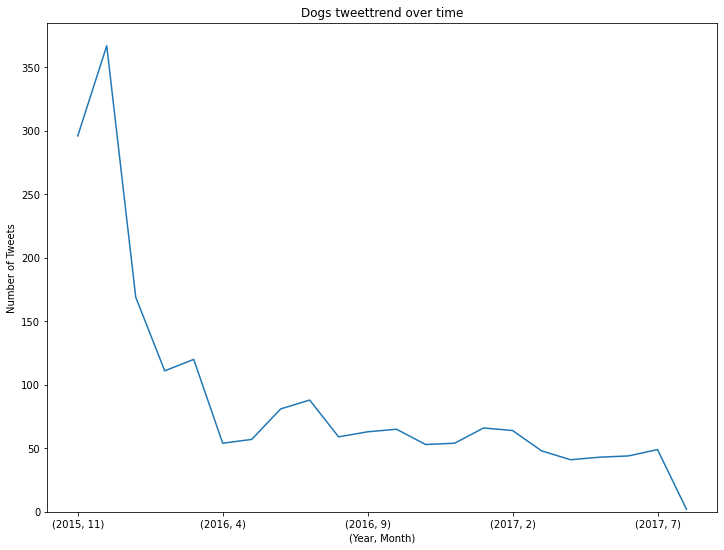

In [259]:
### Visualisation for time stamp using ax values 
data = df.tweet_id.groupby([df["timestamp"].dt.year, df["timestamp"].dt.month]).count()
ax = data.plot(kind='line')
plt.title('Dogs tweettrend over time')
ax.set_title=('Dogs tweettrend over time')
ax.set_xlabel("(Year, Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trend')

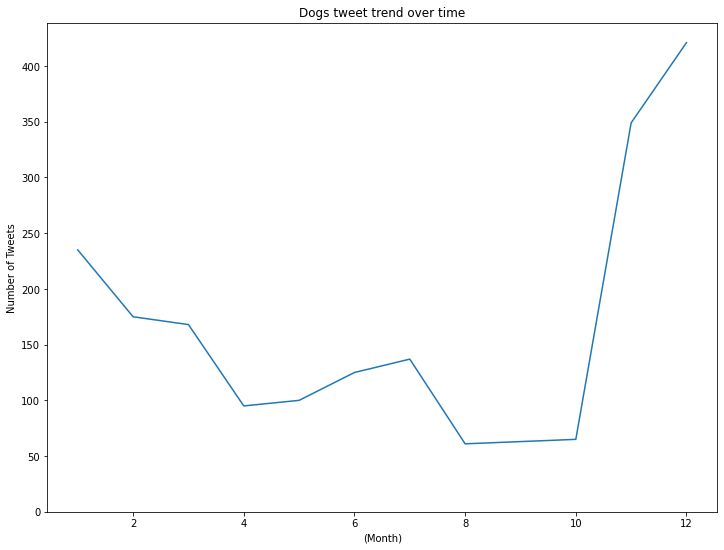

In [296]:
data = df.tweet_id.groupby([df["timestamp"].dt.month]).count()
ax = data.plot(kind='line')
plt.title('Dogs tweet trend over time')
ax.set_title=('Dogs tweet trend over time')
ax.set_xlabel("(Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trend3')

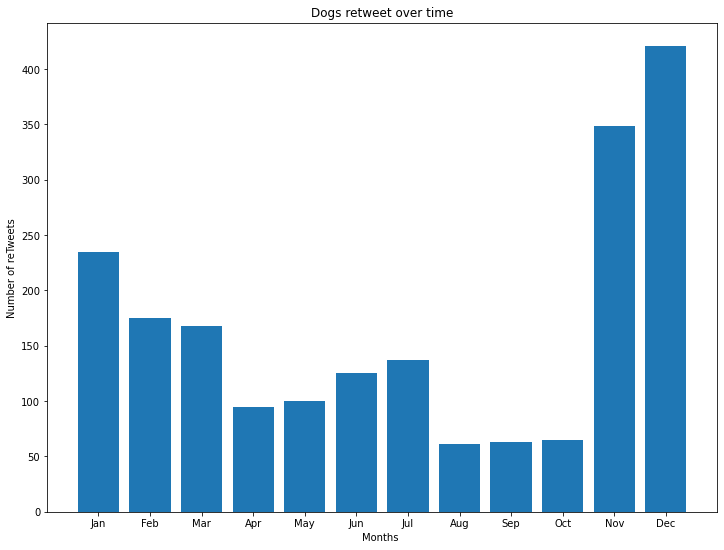

In [297]:
### Visualisation for retweet counts 
avg_retweets = df.retweet_count
data = df.retweet_count.groupby([df["timestamp"].dt.month]).count()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(months, data)
plt.title('Dogs retweet over time')
plt.xlabel('Months ')
plt.ylabel('Number of reTweets');
plt.savefig('tweet_trend')

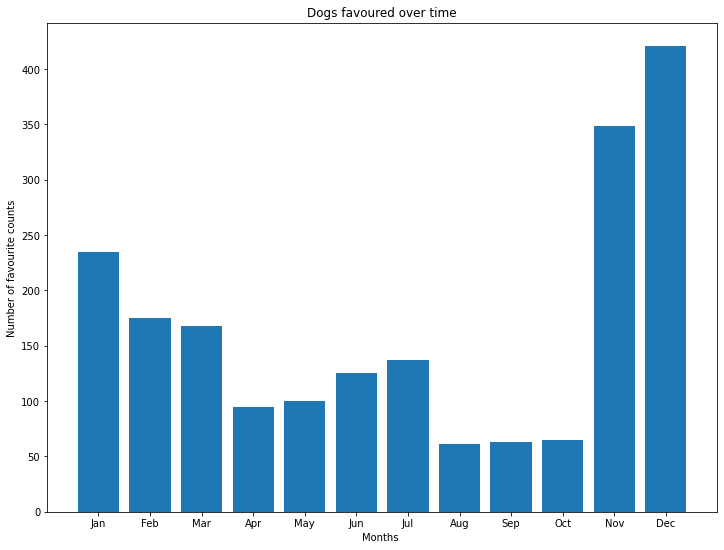

In [298]:
avg_retweets = df.favorite_count
data = df.favorite_count.groupby([df["timestamp"].dt.month]).count()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(months, data)
plt.title('Dogs favoured over time')
plt.xlabel('Months ')
plt.ylabel('Number of favourite counts');
plt.savefig('tweet_trend2')

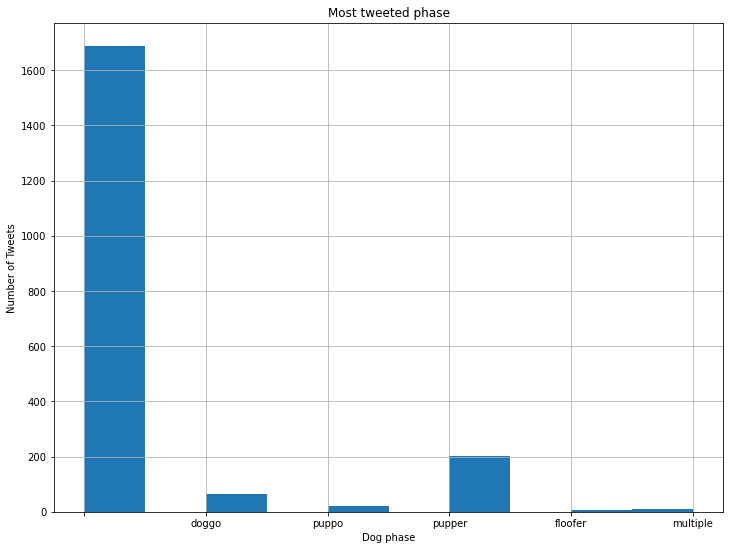

In [301]:
### Visualisation for tweet sources
df['dog_phase'].hist()
plt.title('Most tweeted phase')
plt.xlabel('Dog phase')
plt.ylabel('Number of Tweets');
plt.savefig('Dog phase')

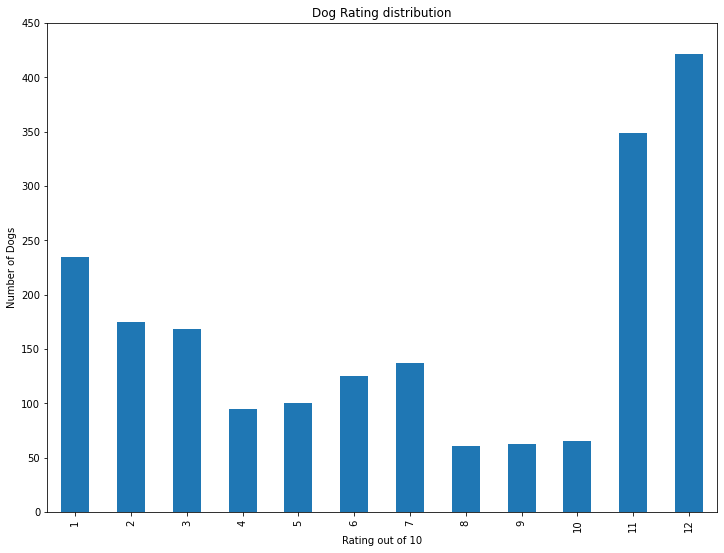

In [293]:
### Visualisation for numerator ratings using ax values 
ax = df.rating_numerator.value_counts().sort_index()
ax = data.plot(kind='bar')
plt.title('Dog Rating distribution')
ax.set_xlabel("Rating out of 10")
ax.set_ylabel("Number of Dogs")
ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
plt.savefig('rating_dist')

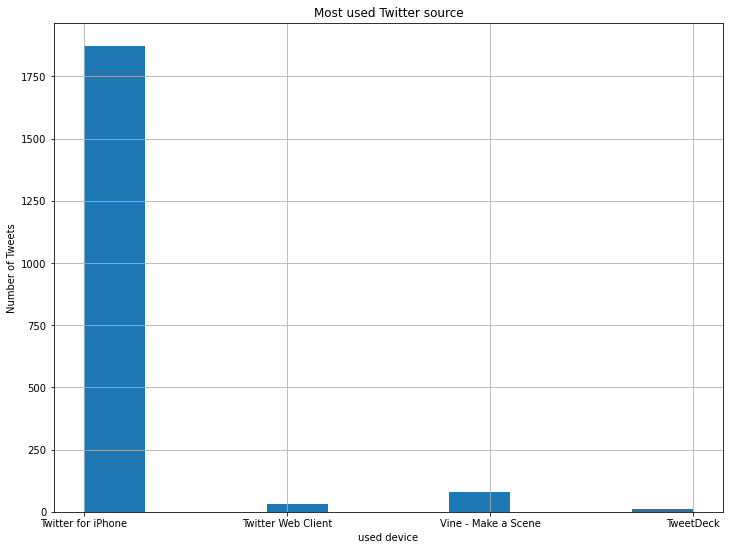

In [294]:
### Visualisation for tweet sources
df['source'].hist()
plt.title('Most used Twitter source')
plt.xlabel('used device')
plt.ylabel('Number of Tweets');
plt.savefig('twitter_source')

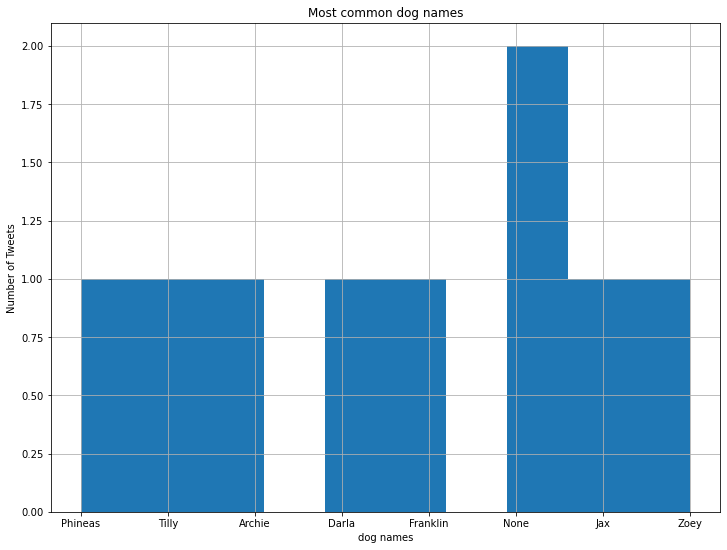

In [310]:
df.name[0:9].hist()
plt.title('Most common dog names')
plt.xlabel('dog names')
plt.ylabel('Number of Tweets');
plt.savefig('dog_names')

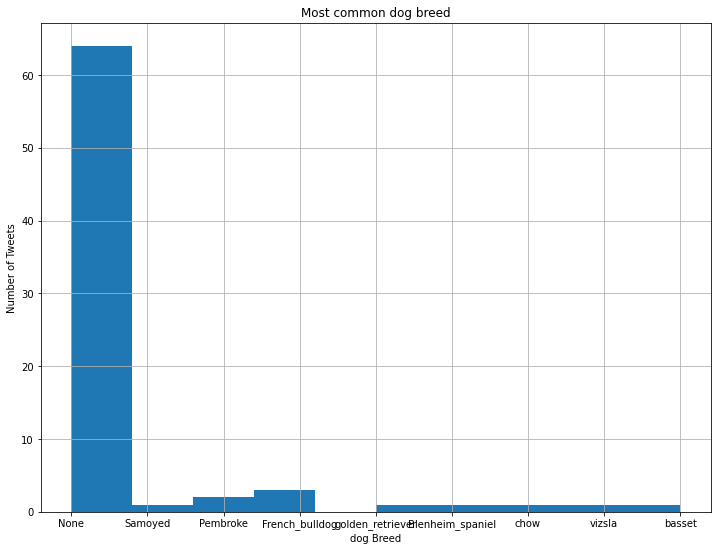

In [323]:
countbreeed=df.breed.value_counts()
df.breed[0:75].hist()
plt.title('Most common dog breed')
plt.xlabel('dog Breed')
plt.ylabel('Number of Tweets');
plt.savefig('dog_breeds')

In [312]:
df['breed'].value_counts()

None                           1808
pug                              20
Samoyed                          19
Pembroke                         19
golden_retriever                 16
Pomeranian                       13
Labrador_retriever                9
Chihuahua                         9
French_bulldog                    8
chow                              7
German_shepherd                   4
Bernese_mountain_dog              4
Shetland_sheepdog                 4
Pekinese                          3
beagle                            3
Blenheim_spaniel                  3
Old_English_sheepdog              3
basset                            2
vizsla                            2
Rottweiler                        2
bull_mastiff                      2
English_springer                  2
cocker_spaniel                    2
keeshond                          2
malamute                          2
Shih-Tzu                          2
dalmatian                         2
Boston_bull                 